In [2]:
import pandas as pd
import numpy as np
import os
import threading
import sys
import time
from datetime import datetime
from utils import utils
from matplotlib import pyplot as plt
import random
import copy

In [4]:
f_ =  "parser/merged_providerRPC_MCR/merged_providerRPC_MCR.csv"
df = pd.read_csv(f_)
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
print(df.shape[0])
ms_list = list(df["msname"].unique())
df = df[df["avg"]>1]
df = df[df["num"] > 1]
df = df.sort_values(by=["std"], ascending=False)
std_sorted_ms = list(df["msname"].unique())
# 10s

874967


In [6]:
original_df = pd.read_csv("original_trace/raw_all_provider_rpc_mcr.csv")
# 2m

In [7]:
li_0 = original_df["msname"].unique()
li_1 = df["msname"].unique()
# 9s

In [8]:
print("len(li_0): ", len(li_0))
print("len(li_1): ", len(li_1))

len(li_0):  1215
len(li_1):  1031


In [9]:
def plot_replica_mcr(mcr_list, msname, idx=0):
    fname = str(idx) + "_callrate_" + msname[:8] + "_numreplica" + str(len(mcr_list))
    title = "Call Rate / " + msname[:8] + " / Num replica=" + str(len(mcr_list))
    plt.figure(figsize=(12, 5))
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 720, 50))
    for mcr in mcr_list:
        # plt.plot(mcr, linewidth=0.5, alpha=0.7)
        plt.plot(mcr, linewidth=1)
        plt.ylabel("Call Rate")
        plt.xlabel("Time")
        plt.title(title)
        # plt.legend(loc="upper right")
    # plt.savefig(fname+".pdf", dpi=100, bbox_inches='tight')
    plt.show()

### Count the number of microburst 

In [13]:
idx = 0
mcr_map = dict()
for ms in ms_list:
    if idx == 1:
        break
    temp_df = df[df["msname"] == ms]
    temp_df = temp_df.sort_values(by=["timestamp"])
    mcr = temp_df["sum"].to_list()
    mcr_map[ms] = mcr
    
# 50s

In [64]:
def detect_microburst(call_rate, window_size, burst_degree):
    burst_ts = list()
    burst_cnt = 0
    burst_detect = 0
    for i in range(window_size, len(call_rate)):
        if burst_detect == 0:
            prev_window_avg = sum(call_rate[i-window_size:i])/window_size
            if call_rate[i] > prev_window_avg * burst_degree:
                burst_cnt += 1
                burst_ts.append(i)
                burst_detect = window_size
        else:
            burst_detect -= 1
    return burst_cnt, burst_ts

In [65]:
sort_by_burstness = list()

ts = time.time()
idx = 0
window_size=5
burst_degree=2
for msname in mcr_map:
    burst_cnt, burst_timestamp = detect_microburst(mcr_map[msname], window_size, burst_degree)
    sort_by_burstness.append([msname, burst_cnt, mcr_map[msname], burst_timestamp])
    # print("index: {}, msname: {}, burst_cnt: {}".format(idx, msname, burst_cnt))
    # if idx == 0:
    #     break
    idx += 1
print("detect_microburst: {} sec".format(time.time() - ts))
    
ts = time.time()
sort_by_burstness.sort(key=lambda x:x[1], reverse=True)
print("sorting: {} sec".format(time.time() - ts))

detect_microburst: 0.29387855529785156 sec
sorting: 0.00044727325439453125 sec


In [54]:
def plot_ms_mcr(msname, burst_cnt, call_rate, burst_ts):
    # msname = elem[0]
    # burst_cnt = elem[1]
    # call_rate_trend = elem[2]
    # burst_ts = elem[3]
    
    fname = "summedup_callrate_" + msname[:8]
    title = "Service Call Rate with Burst / " + msname[:8]
    plt.figure(figsize=(14, 5))
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 720, 50))
    # plt.plot(mcr, linewidth=0.5, alpha=0.7)
    plt.plot(call_rate, linewidth=1, label=msname)
    for ts in burst_ts:
        plt.axvline(x = ts, linewidth=0.5, color="red")
    plt.ylabel("Call rate")
    plt.xlabel("Time")
    plt.title(title)
    plt.legend(loc="upper right")
    # plt.savefig(fname+".pdf", dpi=100, bbox_inches='tight')
    plt.show()

In [68]:
ts = time.time()
sort_by_burstness.sort(key=lambda x:x[1], reverse=True)
for elem in sort_by_burstness:
    print("msname: {}, burst_cnt: {}".format(elem[0], elem[1]))

msname: 0289b9eb4e99a3ee736f1a95aa794231a181ef4ea301f165180e30efdd4c5133, burst_cnt: 72
msname: 44d2cc0752dce00e8735e4d86789022ee68d4dc83d783d14e1cc6a28018b51c1, burst_cnt: 68
msname: 81f9bd417d0c68983c831022af5e232d8e098ebb76326c3a050bde6ce868266b, burst_cnt: 68
msname: 8ddd4272e266357eb5f865b20d017db0588d6a2de6f5f021c62375fbe1503600, burst_cnt: 58
msname: ce374c9db85025c449f191bba59bc3c7a40e05d9ac2fc761ff48a46fb359abc5, burst_cnt: 51
msname: 35fab2d465f68faa3c80b3914045218d4ace703295b997a4c0a8051fdfec6a2e, burst_cnt: 50
msname: 2f631d8fc6683c60a2d67283e22d52a9a1d9b1d24a4b1b7c6cc0f65377757d70, burst_cnt: 47
msname: 7af32c2135c1225df61ca44a4f2e61676d8f59fd21b596d9e21709a2a331c063, burst_cnt: 45
msname: 4599f7a798d7579464bf803f8e465f1c6e72821a327653ba764a4083203f1b6f, burst_cnt: 43
msname: a4e4889c88474d777f3545211ce7dd65e9d2c4bc91296296513864fd7c676550, burst_cnt: 40
msname: 6d9c26b935a837f3658138bf8b5c50d4798d7e491d1d0de01c23d481e399ebbc, burst_cnt: 40
msname: 94f171ca24dac8ee91dc9da6

In [72]:
''' burst statistics '''
burst_cnt_list = [ x[1] for x in sort_by_burstness]
burst_service = [ x for x in sort_by_burstness if x[1] > 0]
print("total num burst: {}".format(sum(burst_cnt_list)))
avg_per_service = sum(burst_cnt_list)/len(burst_cnt_list)
print("average num of burst per service during 12 hours: {}".format(avg_per_service))
print("average num of burst per service per hour: {}".format(avg_per_service/12))
print("num service having at least one burst: {}".format(len(burst_service)))

total num burst: 2703
average num of burst per service during 12 hours: 2.6217264791464596
average num of burst per service per hour: 0.2184772065955383
num service having at least one burst: 264


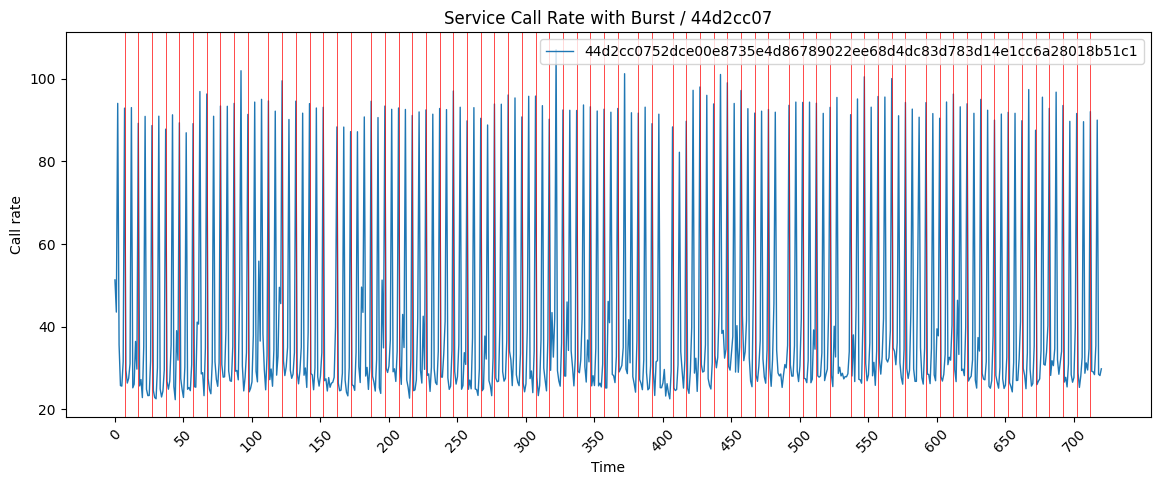

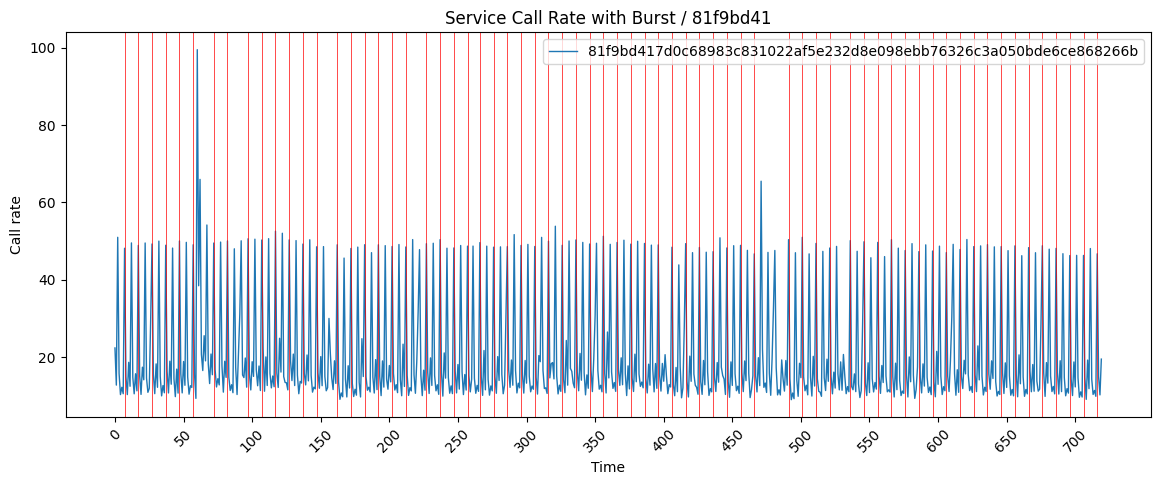

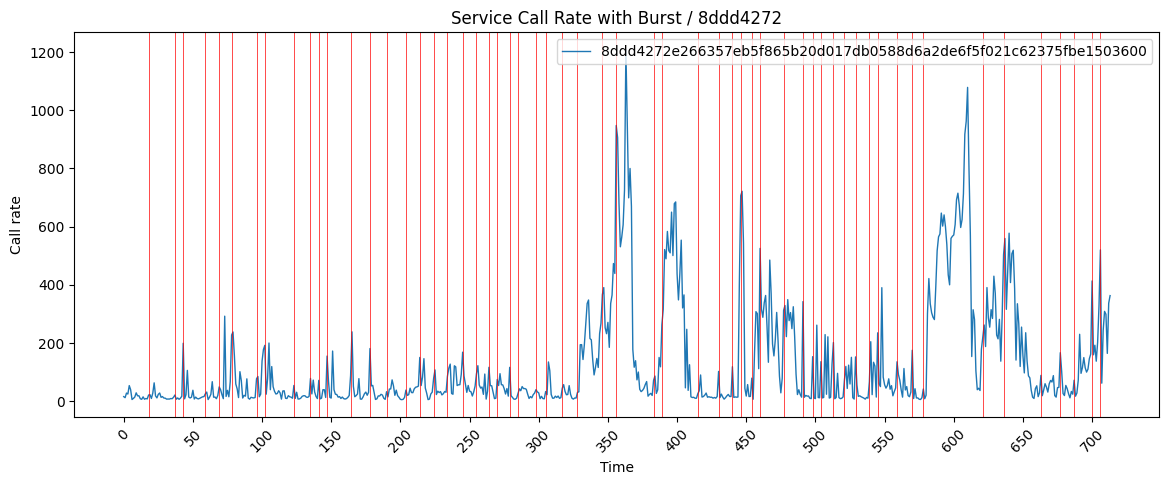

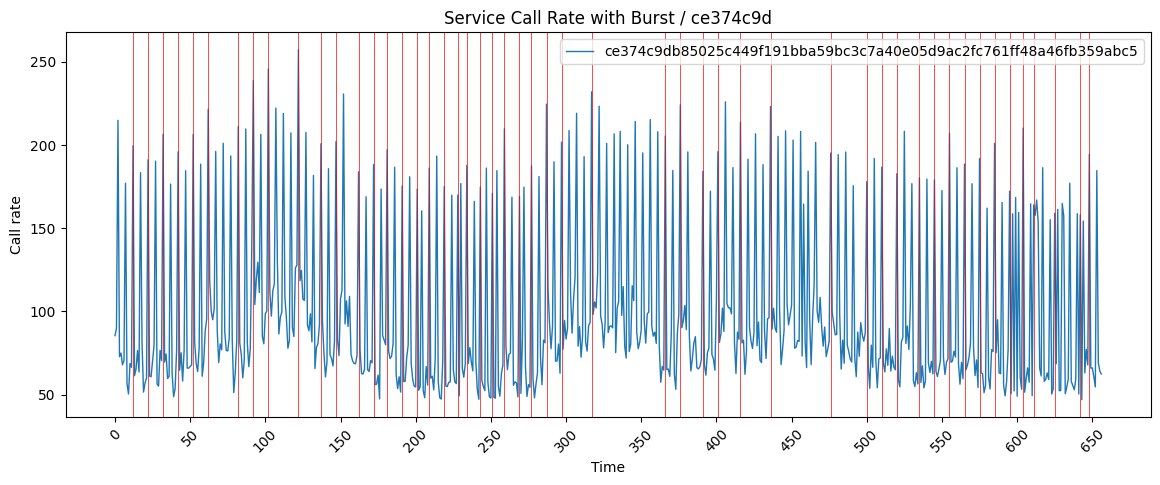

In [76]:
# for i in range(len(sort_by_burstness)):
for i in range(0, 5):
    # elem: [msname, burst_cnt, mcr_map[msname], burst_timestamp]
    elem = sort_by_burstness[i]
    msname = elem[0]
    burst_cnt = elem[1]
    call_rate_trend = elem[2]
    burst_ts = elem[3]
    if burst_cnt > 0:
        plot_ms_mcr(msname, burst_cnt, call_rate_trend, burst_ts)
    else:
        print("{} has no burst in call trend.".format(msname))
        plot_ms_mcr(msname, burst_cnt, call_rate_trend, burst_ts)
    if i == 20:
        break

### - Create mcr_map dictionary
### - You can plot call rate of each replica as well.

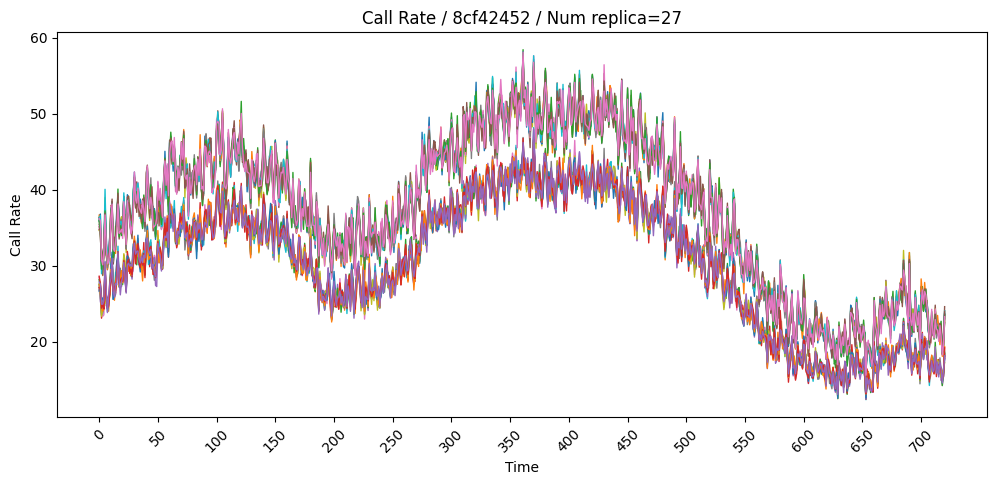

8cf4245297a98f6085ccde5acdce8462e900a8acb25492b7f658fa5ca20a07ed duration for plot: 4.55


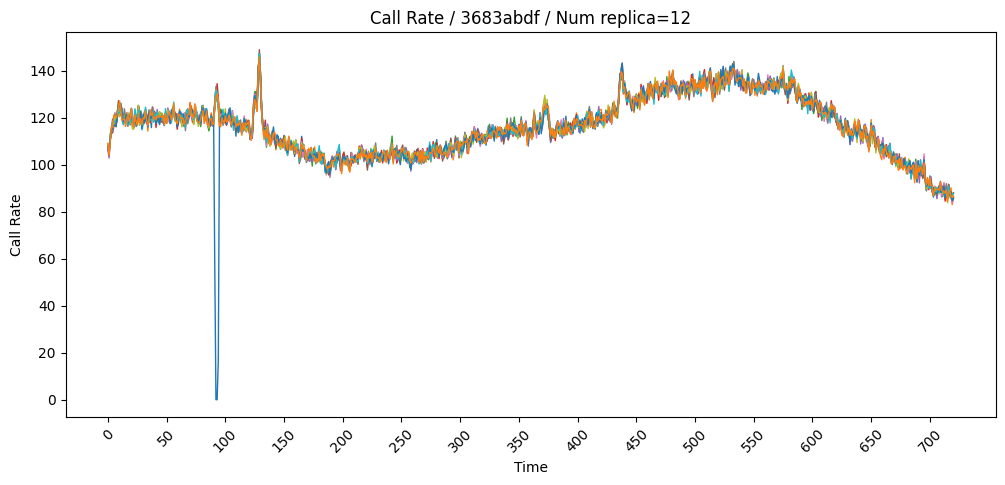

3683abdf465be383b69430d7bba5da7f1d6d74355244ddda6dcbf9ae50e55383 duration for plot: 4.57


237898c9c6be1dcc3bb4a55cec8ec8b938587d211fadcd509081bb17d8828344 duration for plot: 5.96


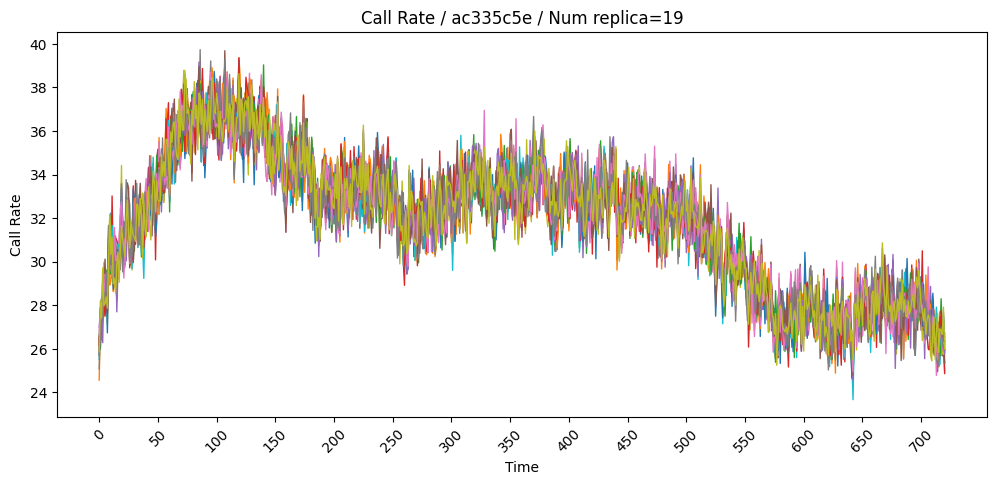

ac335c5efef430651a8b99ea2f2392890962853f3ec950d790543a660d525de1 duration for plot: 4.63


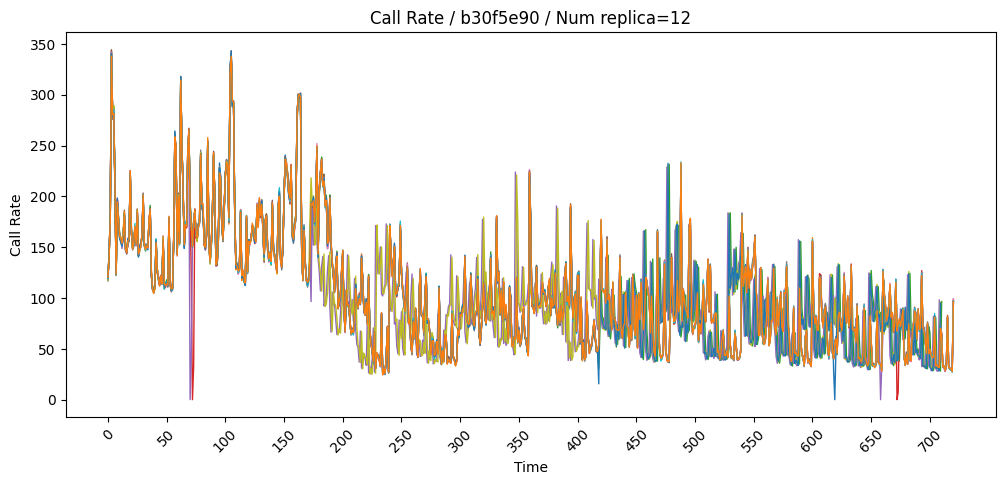

b30f5e900d87aa0c5d314628b32489b5853a40c977ea47d5f15c9ad29024cd45 duration for plot: 4.61


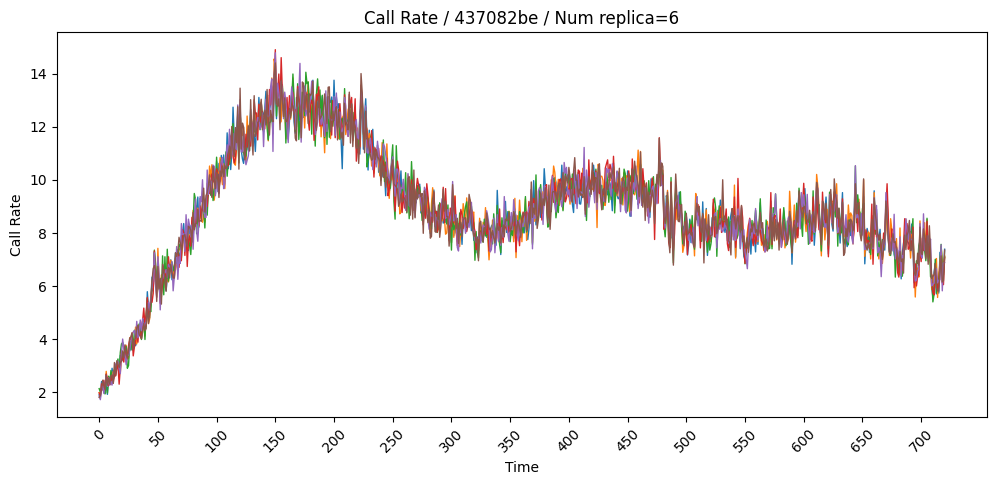

437082be8954e03173044be2e44a09706399d0acbd03c4ca1bc51ba8f9457259 duration for plot: 4.8


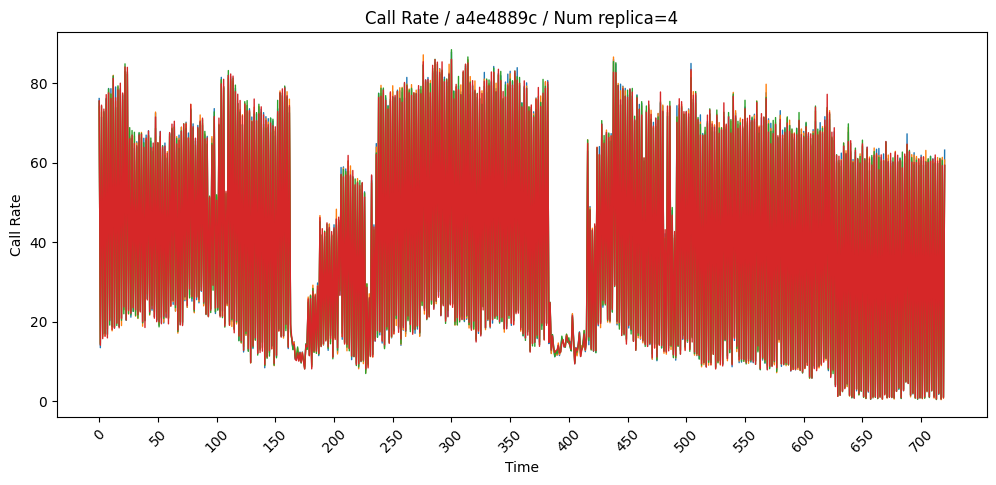

a4e4889c88474d777f3545211ce7dd65e9d2c4bc91296296513864fd7c676550 duration for plot: 4.77


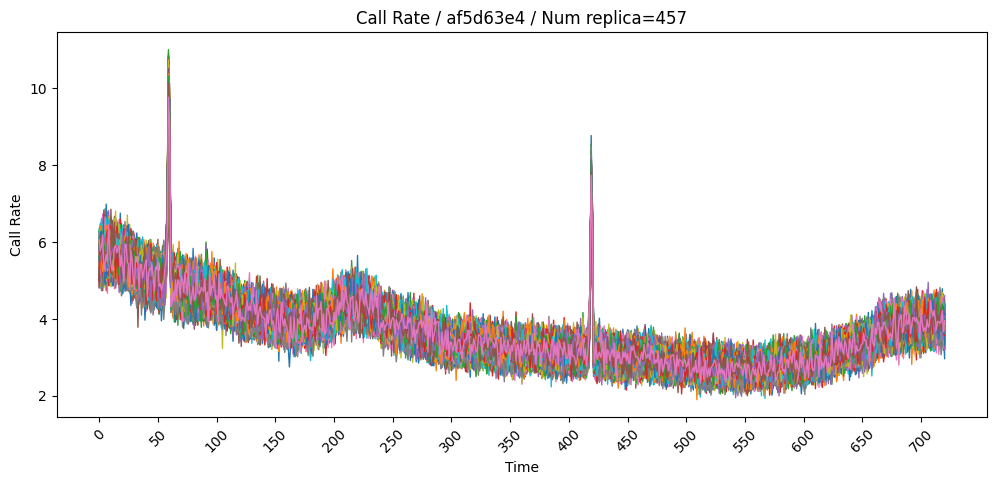

af5d63e40f2bc053c32d2b51ba6ca28739e93661fd816b61e1d2e90736c9643f duration for plot: 16.38


5d3c18d8b4f0aed80c31f3db4c3ef113a73106a41149cd4039f90a1e95d61124 duration for plot: 11.18


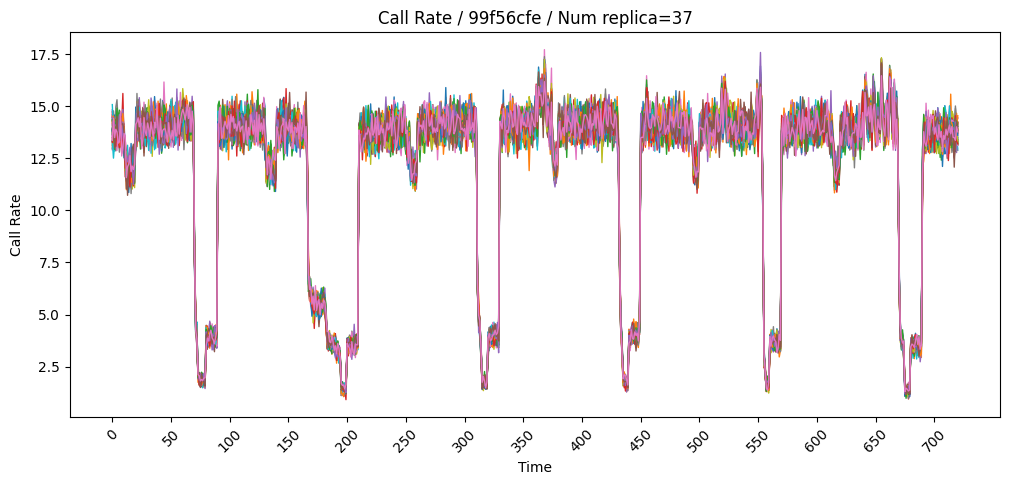

99f56cfedc39972425c9447491e317a65d24a5f6587f885e3b8a5d784e0e92e7 duration for plot: 4.68


147186e34cafc07067650b919d588b948d8ca5baadef071edfef190558d73bce duration for plot: 5.4


f10612cc80a4777bcb0f9025041b3e4a9d8de8b20bfd2dcb0ab1406cbeeaeaf5 duration for plot: 7.26


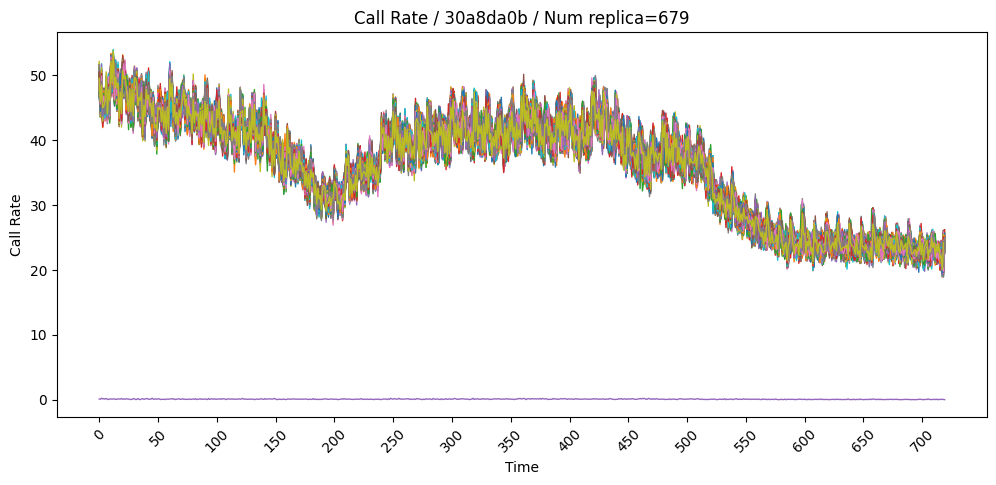

30a8da0bf74d650c3aff9df0a7b34ce90b5be01dcbf3adffa06bbc85061bb428 duration for plot: 29.32


48a7bd8bfc08e9ae0d882f2fec68ff2fdf0c5620e5816e39677408ddf96ba0ea duration for plot: 5.0


f2ff782d57371c090c294859e444ee4bdfb4b317e6836884626ed82b1502dd47 duration for plot: 9.97


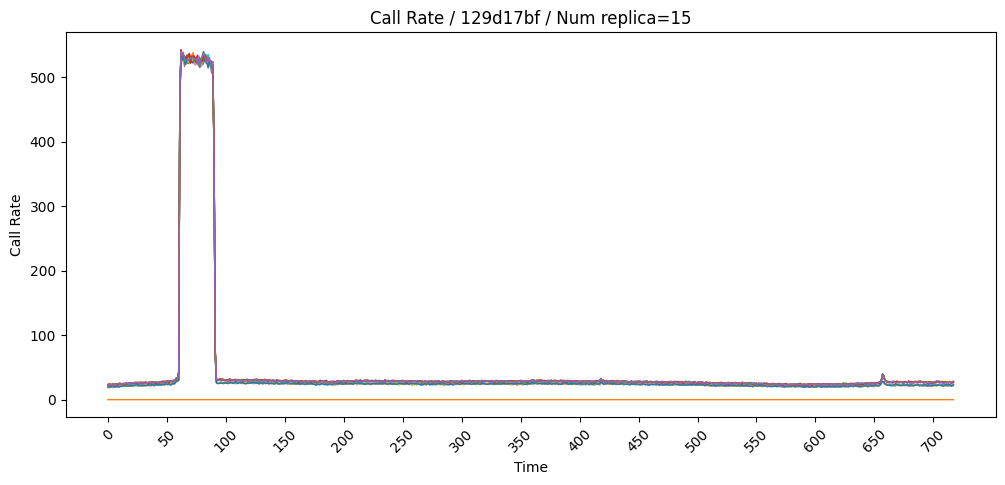

129d17bfd8efe77bd8b1fc2b361d3fed0ee222ba05914350ad5212d3ad9ad26a duration for plot: 4.52


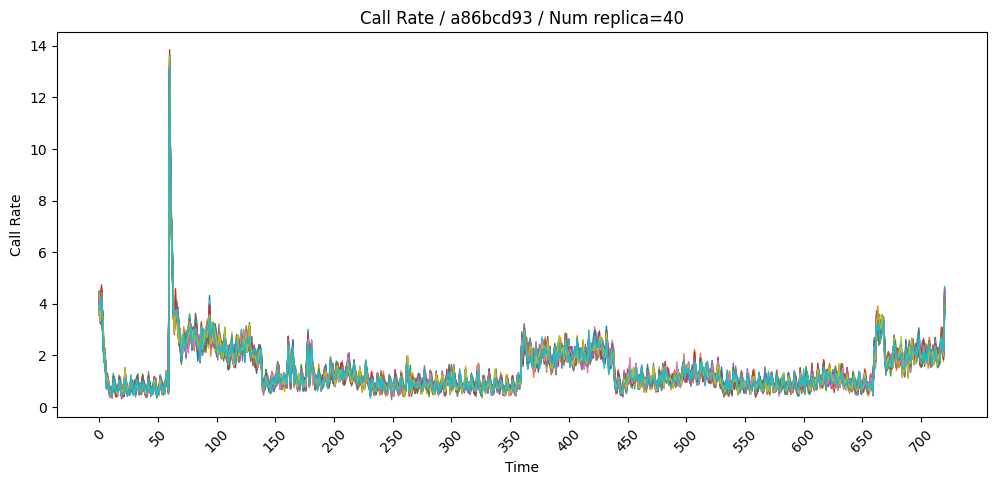

a86bcd9360c8bc9843b59186ba1d8ecf2dd4b5457ed8225e30ca7c47c5555bc2 duration for plot: 4.91


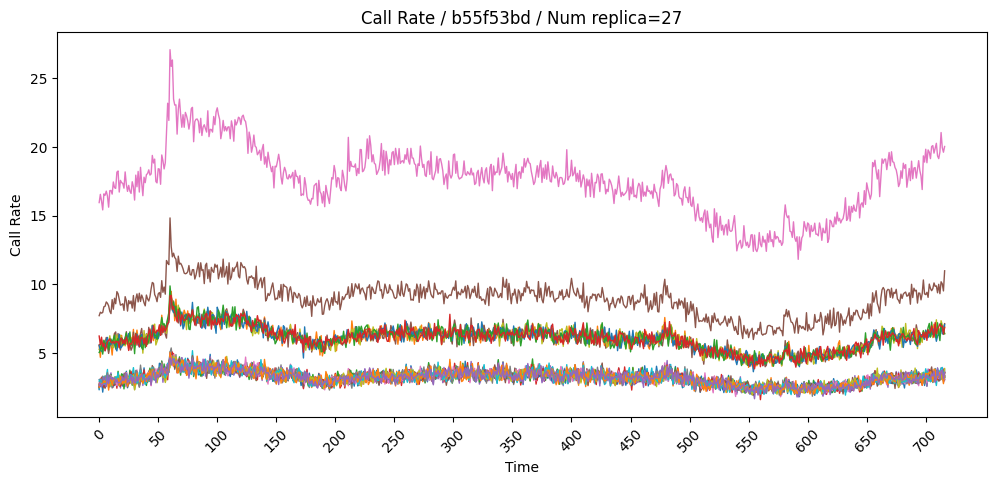

b55f53bd57672c6f738da79abcd4dcdba450da440d70f9c762651e5bc777c61c duration for plot: 4.7


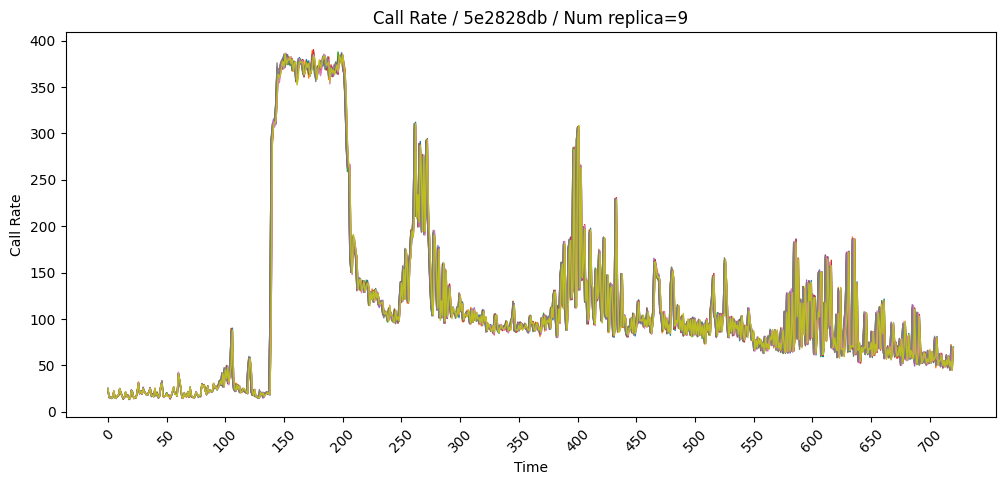

5e2828dbda8044d3da062316aad24b214df466c183b4b2a5cd0e966b075e63a5 duration for plot: 4.53


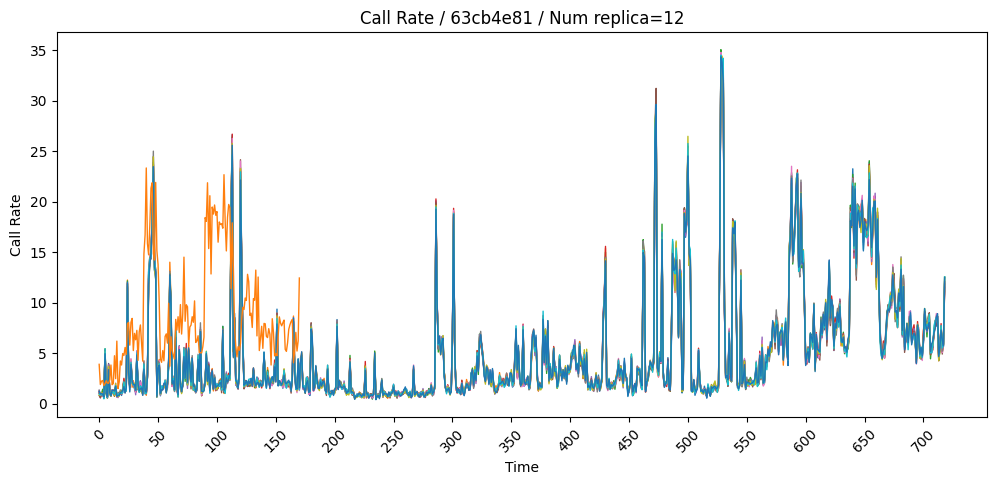

63cb4e810d59a0bf3e1f1588f2367ce81127c913739c70452303a26a65447357 duration for plot: 4.58


In [22]:
idx = 0
# for ms in std_sorted_ms:
mcr_map = dict()
random.seed(1234)
shuffled_ms_list = copy.deepcopy(ms_list)
random.shuffle(shuffled_ms_list)

for ms in shuffled_ms_list:  ## Randomly shuffled ms_name list
# for ms in ms_list: ## Orignal order as it was in the trace.
# for ms in p99p50_sort_ms: ## Sorted ms_name list
    mcr_map[ms] = list()
# for ms in candidate_ms:
    ts = time.time()
    if idx == 20:
        break
    temp_df = original_df[original_df["msname"] == ms]
    temp_df = temp_df.sort_values(by=["timestamp"])
    repl_name = temp_df["msinstanceid"].unique()
    for repl in repl_name:
        repl_df = temp_df[temp_df["msinstanceid"]==repl]
        mcr = repl_df["value"].to_list()
        mcr_map[ms].append(mcr)
    plot_replica_mcr(mcr_map[ms], ms, idx)
    idx += 1
    duration = time.time() - ts
    print(ms + " duration for plot: " + str(round(duration, 2)))

# 5 seconds for each replica.
# total time: 5 * [num service]

# 358e600f0761e77d74c586d61961fc53940fe654180cce128b50a08fc39c7278: very different call rate across replicas
# 6190227e8489cba622c6675f26dbf94a0407dc21594d0dcd6776c46975b7e225: similar trends but different call rate
# e9916393b398199ef017f67a1904dd9c30323405c6f77cb7e238078d1b550a23: kind of in the middle. Still a bit similar trend..?
# cfb6a655058e3019e6e40a24657c92fabfc65859e15647ffbcb01159c8b5be08: kind of in the middle. Still a bit similar trend..?
# 02b687d8b09f6903892c2d15ea8e4a84e0210896c85378be3f498d647db8e37e: Replicas can be clearly separated into two groups. same trend different call rate.

num replica: 108
len(gp0):  54
len(gp1):  54
ERROR: not consistent length of call rate.
len(gp0_call_rate[0]):  202
len(gp1_call_rate[0]):  715
min_len_timestamp of all the replica of group 0 and group 1 :  202


num replica: 180
len(gp0):  90
len(gp1):  90
len(gp0_call_rate[0]):  721
len(gp1_call_rate[0]):  721
min_len_timestamp of all the replica of group 0 and group 1 :  721


num replica: 92
len(gp0):  46
len(gp1):  46
len(gp0_call_rate[0]):  721
len(gp1_call_rate[0]):  721
min_len_timestamp of all the replica of group 0 and group 1 :  721


num replica: 261
len(gp0):  130
len(gp1):  131
ERROR: not consistent length of call rate.
len(gp0_call_rate[0]):  720
len(gp1_call_rate[0]):  720
min_len_timestamp of all the replica of group 0 and group 1 :  720


num replica: 104
len(gp0):  52
len(gp1):  52
ERROR: not consistent length of call rate.
len(gp0_call_rate[0]):  721
len(gp1_call_rate[0]):  721
min_len_timestamp of all the replica of group 0 and group 1 :  718


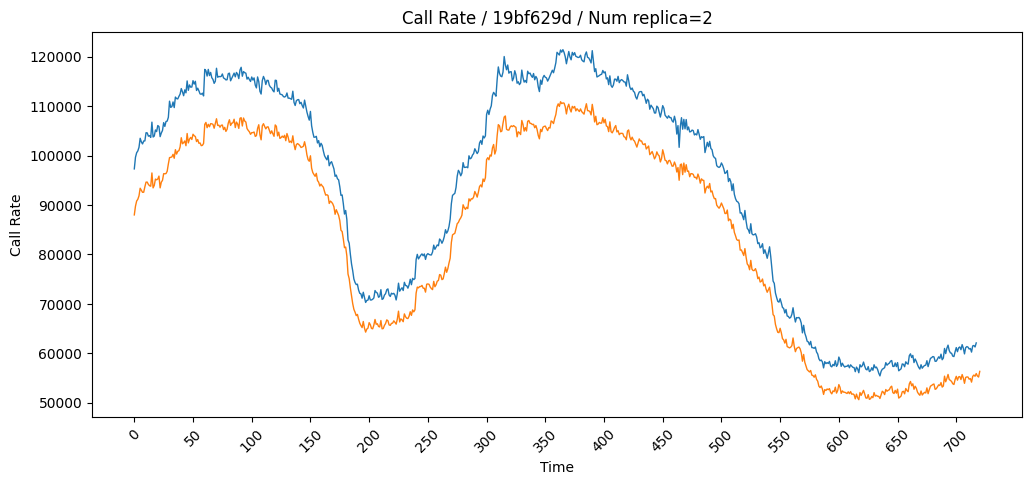

In [26]:
# target_ms_0 = "358e600f0761e77d74c586d61961fc53940fe654180cce128b50a08fc39c7278"
# target_ms_1 = "6190227e8489cba622c6675f26dbf94a0407dc21594d0dcd6776c46975b7e225"

def cluster_and_plot(mcr_map, ms_name):
    ''' 
        Method 1. Block box approach: Simply first half and second half will be the first replica group and the second replica group respectively.
        Method 2. Sort the replicas by the average call rate and divide them into two groups.
    '''
    def split_into_two_groups(call_rate):
        # print("target microservice: " + msname)
        assert len(call_rate) > 0
        print("num replica: " + str(len(call_rate)))
        def calc_avg_call_rate(li):
            return sum(li)/len(li)
        avg_list = list()
        repl_idx = 0
        for cr in call_rate:
            avg_list.append([repl_idx, calc_avg_call_rate(cr), cr])
            repl_idx += 1
            
        
        # SORT!
        avg_list.sort(key=lambda x: x[1], reverse=True)
        # for i in range(0, 10):
        #     print("{}, {}".format(avg_list[i][0], avg_list[i][1]))
        gp0 = list()
        gp1 = list()
        mid_idx = int(len(avg_list)/2)
        for i in range(mid_idx):
            gp0.append(avg_list[i])
        for i in range(mid_idx, len(avg_list)):
            gp1.append(avg_list[i])
        return gp0, gp1

    # p99p50_sort_ms[1]: service name
    # mcr_map[p99p50_sort_ms[1]]: [ [repl_0's call rate], [repl_1's call rate], ... ]
    
    # gp0, gp1 = split_into_two_groups(mcr_map[p99p50_sort_ms[1]])
    gp0, gp1 = split_into_two_groups(mcr_map[ms_name])
    
    # gp0: [ [repl idx, avg call rate of the repl, call rate list of the repl], ... ]
    # gp0[0][0]: high avg call rate replica idx
    # gp0[0][1]: avg call rate of this replica
    # gp0[0][2]: actual list of call rate over time
    # The element of gp0 is each replica's call rate over time.
    # The gp0, gp1 lists are sorted by the average call rate of each replica.
    print("len(gp0): ", len(gp0))
    print("len(gp1): ", len(gp1))

    # for i in range(len(gp0)):
    #     print(gp0[i][0])
    #     if i == 5:
    #         break
    # print()
    # for i in range(len(gp1)):
    #     print(gp1[i][0])
    #     if i == 5:
    #         break

    # gp0_call_rate = [ call rate of the first replic, call rate of the second replica, ... ]
    # Each element of gp0_call_rate list is each replica's call rate.
    # Each call rate is sorted by the timestamp.
    # e.g., gp0_call_rate[0]: call rate of the first replica.
    
    gp0_call_rate = [elem[2] for elem in gp0]
    gp1_call_rate = [elem[2] for elem in gp1]

    # assert len(gp0_call_rate) != len(gp1_call_rate)
    
    for i in range(0, len(gp0_call_rate)-1):
        if len(gp0_call_rate[i]) != len(gp0_call_rate[i+1]):
            print("ERROR: not consistent length of call rate.")
            break
        
    print("len(gp0_call_rate[0]): ", len(gp0_call_rate[0]))
    print("len(gp1_call_rate[0]): ", len(gp1_call_rate[0]))


    # i: timestamp
    # j:
    cluster_0 = list()
    cluster_1 = list()
    
    min_len_timestamp = 999999
    for i in range(len(gp0_call_rate)):
        min_len_timestamp = min(min_len_timestamp, len(gp0_call_rate[i]))
    for i in range(len(gp1_call_rate)):
        min_len_timestamp = min(min_len_timestamp, len(gp1_call_rate[i]))
        
    print("min_len_timestamp of all the replica of group 0 and group 1 : ", min_len_timestamp)
    # for i in range(len(gp0_call_rate[0])):
    for i in range(min_len_timestamp):
        cr_sum = 0
        for j in range(min(len(gp0_call_rate), len(gp1_call_rate))):
            cr_sum += gp0_call_rate[j][i]
        cluster_0.append(cr_sum)
        
    for i in range(len(gp1_call_rate[0])):
        cr_sum = 0
        for j in range(len(gp1_call_rate)):
            cr_sum += gp1_call_rate[j][i]
        cluster_1.append(cr_sum)
        
        
    plot_replica_mcr([cluster_0, cluster_1], ms_name)
    
cluster_and_plot(mcr_map, p99p50_sort_ms[0])
cluster_and_plot(mcr_map, p99p50_sort_ms[1])
cluster_and_plot(mcr_map, p99p50_sort_ms[2])
cluster_and_plot(mcr_map, p99p50_sort_ms[3])
cluster_and_plot(mcr_map, p99p50_sort_ms[4])

## Parse original provider RPC MCR file to create providerRPC MCR stat for each microservice 
#### 1. Collapse msinstanceid(replicas). Now one entry for each service per a timestamp.
#### 2. Collapse timestamp. Now one entry for each service. Each entry has statistics of call rate of multiple replicas for a timestamp.

In [28]:
def get_stat_list(msname_, li_):
    if np.average(li_) == -1:
        print("[ERROR]: li_ is invalid sum_list.")
    stat_list = list()
    stat_list.append(msname_)
    stat_list.append(np.average(li_))
    stat_list.append(np.std(li_))
    
    sorted_li = np.sort(li_, axis = 0)
    min_ = sorted_li[0]
    for elem in sorted_li:
        if elem != -1 and elem != 0:
            min_ = elem
            break
    # print(sorted_li)
    # print("min: ", min_)
        
    stat_list.append(max(li_) - min_)
    
    if min_ == 0:
        stat_list.append(float('inf'))
    else:
        stat_list.append(max(li_)/min_)
    stat_list.append(max(li_)/np.percentile(li_, 1)) # max/p1
    stat_list.append(max(li_)/np.percentile(li_, 75)) # max/p75
    stat_list.append(max(li_)/np.percentile(li_, 50)) # max/p50
    stat_list.append(np.percentile(li_, 99)/np.percentile(li_, 50)) # p99/p50
    stat_list.append(max(li_)/np.average(li_)) # max/avg
    stat_list.append(np.percentile(li_, 99)/np.average(li_)) # p99/avg
    stat_list.append(min_)
    stat_list.append(max(li_))
    stat_list.append(np.percentile(li_, 1))
    stat_list.append(np.percentile(li_, 10))
    stat_list.append(np.percentile(li_, 25))
    stat_list.append(np.percentile(li_, 50))
    stat_list.append(np.percentile(li_, 75))
    stat_list.append(np.percentile(li_, 90))
    stat_list.append(np.percentile(li_, 99))
    for x in li_:
        stat_list.append(x)
    for i in range(721 - len(li_)): #NOTE: hardcoded timestamp lenght
        stat_list.append(np.nan)
    stat_list.append(li_)
    return stat_list



In [26]:
timestamps = list()
for ts in range(0, 43260000, 60000):
    # timestamps.append("ts_"+str(int(ts/60000)))
    timestamps.append(str(int(ts/60000)))
print(timestamps[0])
print(timestamps[1])
print(timestamps[-1])

0
1
720


In [29]:

df_list = list()
msname_list = df["msname"].unique()
col = ["msname", "avg", "std", "max-min", "max/min", "max/p1", "max/p75", "max/p50", "p99/p50", "max/avg", "p99/avg", "min", "max", "p1", "p10", "p25", "p50", "p75", "p90", "p99"]
col = col + timestamps
col.append("li")
stat_df = pd.DataFrame(columns= col)
for msname in msname_list:
    temp_df = df[df["msname"] == msname]
    df_list.append(temp_df)
    sum_list = temp_df["sum"].values.tolist()
    if np.average(sum_list) != -1 and max(sum_list) != 0:
        sum_list = [x for x in sum_list if x != 0]
        ms_stat = get_stat_list(msname, sum_list)
        stat_df.loc[len(stat_df.index)] = ms_stat

# execution time: 2m 33s        

In [6]:
sorted_stat_df = stat_df.sort_values(by=["p99/p50"], ascending=False)
print(sorted_stat_df.shape)
# display(sorted_stat_df)

(1214, 742)


In [15]:
filtered_df = sorted_stat_df[sorted_stat_df["avg"] > 1]
print(filtered_df.shape)
filtered_df = filtered_df[filtered_df["min"] > 1]
filtered_df = filtered_df.reset_index(drop = True)
print(filtered_df.shape)
display(filtered_df)

(1119, 742)
(1043, 742)


msname           avg  \
0     c9309a1d87d569ae3d33cc016a6df86bf980553640f00d...    124.116435   
1     fdc013a14038212380fa44ed533668ed12a59cde09c928...    692.635876   
2     358e600f0761e77d74c586d61961fc53940fe654180cce...  34537.538234   
3     c4588e0964a9ba7d4c521f4d17c9bca3b08196fef6d150...     12.453807   
4     64ff81a6afa87476179945775ef71fcf2e6f80cc3ca2e4...     72.615141   
...                                                 ...           ...   
1038  a828cf949747f47b182e8269b324b8948f97330f6104f9...  94868.771244   
1039  65ceb2782457ad9400b7668fc02d3ad3d79f86469b2be8...  43713.071405   
1040  719faf5996d9961657ac692193630de32d3c7c976b2031...  50627.794591   
1041  e9293802f63781a2e08fbc9de44d542ebd9ddf4a17cf9a...   1754.642071   
1042  4d980b8ae1f1da1a302d77ef91b9f9dd4e841856f6cdd4...  17234.890139   

               std        max-min     max/min      max/p1    max/p75  \
0       300.534362    1177.750000  570.879032  453.921129  47.765857   
1      1888.985928   23777.633333  246.383213  236.124353  93.662351   
2     79681.343569  372818.950000  372.401435  286.844013  25.746847   
3        32.307853     303.700000  144.480315  128.909653  29.218153   
4       120.029960     641.050000  166.788793  142.261029   6.808904   
...            ...            ...         ...         ...        ...   
1038   5743.183012   24286.650000    1.300635    1.274127   1.060728   
1039   3155.066111   16541.116667    1.451234    1.439287   1.155713   
1040   2931.300092   40097.983333    3.789477    1.258745   1.034677   
1041     66.016973     379.016667    1.254274    1.221774   1.039234   
1042    806.848970    4072.066667    1.281186    1.246428   1.038849   

         max/p50     p99/p50    max/avg  ...           712           713  \
0     109.242284  107.667407   9.505725  ...      3.866667      3.166667   
1     141.576596   53.905120  34.469097  ...    140.966667    160.650000   
2      48.299283   41.067737  10.823666  ...   4293.683333   4584.133333   
3      40.911929   34.784080  24.556079  ...      4.700000      4.216667   
4      32.848048   30.586927   8.881297  ...      4.250000      4.766667   
...          ...         ...        ...  ...           ...           ...   
1038    1.081285    1.057362   1.107543  ...  95917.350000  95531.850000   
1039    1.182904    1.056086   1.216995  ...  45302.600000  45146.866667   
1040    1.055971    1.047003   1.075945  ...  52870.583333  52919.683333   
1041    1.054415    1.045022   1.065516  ...   1801.016667   1802.133333   
1042    1.057926    1.037590   1.076528  ...  18053.733333  17984.683333   

               714           715           716           717           718  \
0         3.350000      2.550000      2.816667      3.133333      2.516667   
1       159.983333    153.166667    146.633333    140.666667    171.133333   
2      3950.900000   4582.333333   3908.283333   4330.316667   5291.133333   
3         2.466667      3.233333      2.366667      4.383333           NaN   
4         4.783333      5.800000      6.400000      7.133333      6.833333   
...            ...           ...           ...           ...           ...   
1038  96043.750000  95996.650000  96930.216667  97465.300000  98296.616667   
1039  45382.816667  45545.433333  45701.233333  45759.683333  45794.966667   
1040  52871.133333  52993.916667  53161.816667  53294.116667  53486.350000   
1041   1799.016667   1801.533333   1800.083333   1796.050000   1788.966667   
1042  18019.433333  18092.066667  18136.650000  18150.816667  18115.083333   

               719           720  \
0        41.066667           NaN   
1       170.733333    162.150000   
2      6647.416667   5165.883333   
3              NaN           NaN   
4         5.383333     64.783333   
...            ...           ...   
1038  98391.466667  99019.450000   
1039  46030.983333  46328.283333   
1040  53440.083333  53930.816667   
1041   1802.016667   1846.716667   
1042  18276.816667           NaN   

                        

In [8]:
''' Uncomment if you want to save the df to csv file'''
# filtered_df.to_csv("filtered_sorted_merged_providerRPC_MCR.csv")

# Plot

In [18]:
p50_threshold = 1000
double_filtered_df = filtered_df[filtered_df["p50"] > p50_threshold]
double_filtered_df = double_filtered_df.reset_index(drop = True)
double_filtered_df

msname           avg  \
0    358e600f0761e77d74c586d61961fc53940fe654180cce...  34537.538234   
1    75e4a89559db6beb8fcef2e1ebc8a2a1b4bc42b99c2726...   3098.422538   
2    88714911bb43c7aba982a0fc876eae066dba86e82e0d94...   2839.439514   
3    d17f58c4324b523992e8f479804b65a5b965f94877139b...   2809.991040   
4    0289b9eb4e99a3ee736f1a95aa794231a181ef4ea301f1...   5251.334582   
..                                                 ...           ...   
429  a828cf949747f47b182e8269b324b8948f97330f6104f9...  94868.771244   
430  65ceb2782457ad9400b7668fc02d3ad3d79f86469b2be8...  43713.071405   
431  719faf5996d9961657ac692193630de32d3c7c976b2031...  50627.794591   
432  e9293802f63781a2e08fbc9de44d542ebd9ddf4a17cf9a...   1754.642071   
433  4d980b8ae1f1da1a302d77ef91b9f9dd4e841856f6cdd4...  17234.890139   

              std        max-min     max/min      max/p1    max/p75  \
0    79681.343569  372818.950000  372.401435  286.844013  25.746847   
1     3861.058188   21112.200000   23.771073   16.950608   8.687569   
2     2952.843266   18887.166667   10.923031   10.735205   8.447173   
3     2475.466826   18889.133333   13.392547   12.915784   7.673934   
4     4461.145218   13141.500000    8.800884    8.527275   1.373363   
..            ...            ...         ...         ...        ...   
429   5743.183012   24286.650000    1.300635    1.274127   1.060728   
430   3155.066111   16541.116667    1.451234    1.439287   1.155713   
431   2931.300092   40097.983333    3.789477    1.258745   1.034677   
432     66.016973     379.016667    1.254274    1.221774   1.039234   
433    806.848970    4072.066667    1.281186    1.246428   1.038849   

       max/p50    p99/p50    max/avg  ...           712           713  \
0    48.299283  41.067737  10.823666  ...   4293.683333   4584.133333   
1    10.104695   9.679798   7.113087  ...   1409.850000   1379.466667   
2     9.395825   8.861010   7.322055  ...   2534.650000   2536.083333   
3     9.045404   7.300772   7.264566  ...   2960.583333   3281.366667   
4     6.601659   6.432328   2.823305  ...   1832.483333   1874.350000   
..         ...        ...        ...  ...           ...           ...   
429   1.081285   1.057362   1.107543  ...  95917.350000  95531.850000   
430   1.182904   1.056086   1.216995  ...  45302.600000  45146.866667   
431   1.055971   1.047003   1.075945  ...  52870.583333  52919.683333   
432   1.054415   1.045022   1.065516  ...   1801.016667   1802.133333   
433   1.057926   1.037590   1.076528  ...  18053.733333  17984.683333   

              714           715           716           717           718  \
0     3950.900000   4582.333333   3908.283333   4330.316667   5291.133333   
1     1366.766667   1344.850000   1348.150000   1226.000000   1328.566667   
2     2720.833333   3033.833333   3015.950000   2969.800000   7758.800000   
3     3203.083333   3254.450000   6997.683333   9465.700000           NaN   
4     1803.550000   1795.233333   1757.283333   1778.783333   1710.616667   
..            ...           ...           ...           ...           ...   
429  96043.750000  95996.650000  96930.216667  97465.300000  98296.616667   
430  45382.816667  45545.433333  45701.233333  45759.683333  45794.966667   
431  52871.133333  52993.916667  53161.816667  53294.116667  53486.350000   
432   1799.016667   1801.533333   1800.083333   1796.050000   1788.966667   
433  18019.433333  18092.066667  18136.650000  18150.816667  18115.083333   

              719           720  \
0     6647.416667   5165.883333   
1     1266.033333  21406.833333   
2     8453.516667           NaN   
3             NaN           NaN   
4     1684.616667  11194.916667   
..            ...           ...   
429  98391.466667  99019.450000   
430  46030.983333  46328.283333   
431  53440.083333  53930.816667   
432   1802.016667   1846.716667   
433  18276.816667           NaN   

                                                    li  
0    [1003.8166666666672, 1656.1000000000004, 1180

In [19]:
''' Specify df you want to analyze '''
# target_df = filtered_df
target_df = double_filtered_df

In [20]:
for threshold in range(0, 20, 2):
    print(threshold, end=", ")
    print(target_df[target_df["max/p50"] > threshold].shape[0], end=", ")
    print(target_df[target_df["p99/p50"] > threshold].shape[0], end=", ")
    print(target_df[target_df["p99/avg"] > threshold].shape[0])

0, 434, 434, 434
2, 89, 46, 37
4, 12, 8, 5
6, 8, 5, 3
8, 5, 3, 1
10, 3, 1, 0
12, 1, 1, 0
14, 1, 1, 0
16, 1, 1, 0
18, 1, 1, 0


In [21]:
def get_percentile(li_):
    percentile_list = list()
    percentile_list.append(min(li_))
    percentile_list.append(np.percentile(li_, 1))
    percentile_list.append(np.percentile(li_, 10))
    percentile_list.append(np.percentile(li_, 25))
    percentile_list.append(np.percentile(li_, 50))
    percentile_list.append(np.percentile(li_, 75))
    percentile_list.append(np.percentile(li_, 90))
    percentile_list.append(np.percentile(li_, 99))
    percentile_list.append(max(li_))
    return percentile_list

def get_norm_value(li_, norm_by):
    percentile_list = list()
    percentile_list.append(np.percentile(li_, 1) / norm_by)
    percentile_list.append(np.percentile(li_, 10)/ norm_by)
    percentile_list.append(np.percentile(li_, 25)/ norm_by)
    percentile_list.append(np.percentile(li_, 50)/ norm_by)
    percentile_list.append(np.percentile(li_, 75)/ norm_by)
    percentile_list.append(np.percentile(li_, 90)/ norm_by)
    percentile_list.append(np.percentile(li_, 99)/ norm_by)
    return percentile_list

def plot_cdf(data_list, title, xl, yl):
    xl = xl.split(".")[0]
    xl = xl.split("/")[1]
    for data_pair in data_list:
        p50 = round(data_pair[0], 2)
        data_ = data_pair[1]
        x = np.sort(data_)
        num_data_point = len(data_)
        y = np.arange(num_data_point) / float(num_data_point)
        plt.plot(x, y, linewidth=1, label="p50: " + str(p50)) # , marker='x'
        # plt.plot(x, y, marker='x', linewidth=1, label='CDF')
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.gcf().set_dpi(150)
    plt.show()
    plt.savefig("output/" + xl + ".png", bbox_inches='tight')


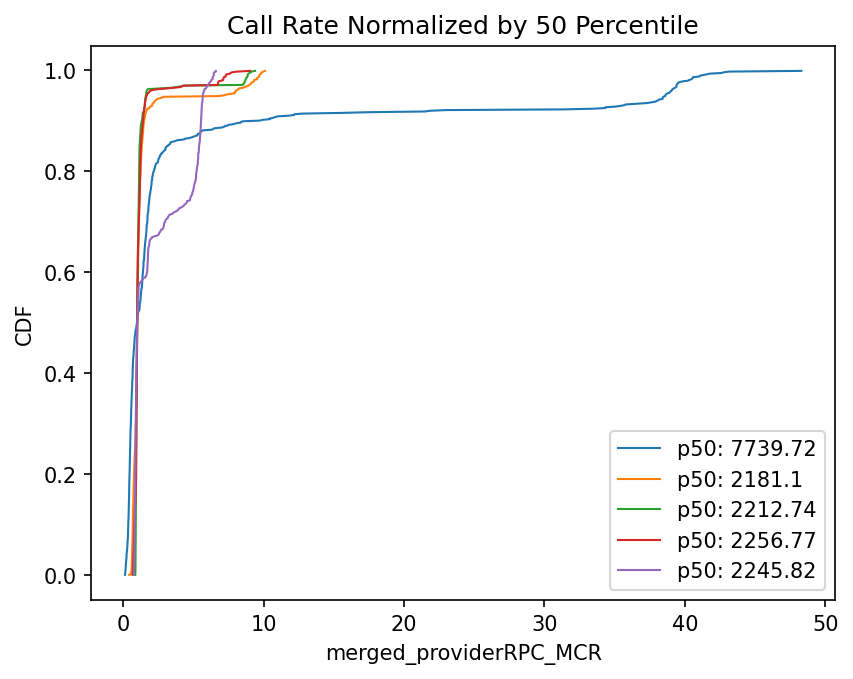

<Figure size 640x480 with 0 Axes>

In [22]:
msname_mcr_list = target_df["li"].values.tolist()

msname_mcr_percentile = list()
for li_ in msname_mcr_list:
    msname_mcr_percentile.append(get_percentile(li_))

norm_mcr = list()
for li_ in msname_mcr_list:
    # norm_mcr.append(get_norm_value(li_, np.percentile(li_, 50)))
    p50 = np.percentile(li_, 50)
    norm_mcr.append([p50, li_/p50])
    
# plot_cdf(msname_mcr_list[2:3], "Provider RPC MCR", "Call Rate", "CDF")
# plot_cdf(msname_mcr_percentile[:3], "Percentile of Provider RPC MCR", "Call Rate", "CDF")
plot_cdf(norm_mcr[:5], "Call Rate Normalized by 50 Percentile", f_name, "CDF")

## Plot Call Rate over time
#### time unit: 60000ms (1 min)
#### total trace:  12 hours
#### num of data points: 721 (60 * 12 + 1 = 721)

In [71]:
def plot_entire_call_rate_trend(y_data, title, xl, yl, label_):
    plt.figure(figsize=(12, 3))
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 720, 50))
    plt.plot(y_data, linewidth=1, label="p99/p50: " + str(round(label_, 2)))
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.legend(loc="upper right")
    plt.gcf().set_dpi(100)
    plt.show()
    # plt.savefig("output/" + xl + ".png", bbox_inches='tight')


In [77]:
def plot_partial_call_rate_trend(x_data, y_data, title, xl, yl, label_):
    plt.figure(figsize=(6, 3))
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 720, 5))
    # plt.plot(x_data, y_data, linewidth=1, label="p99/p50: " + str(round((label_, 2))))
    plt.plot(y_data, linewidth=1, label="p99/p50: " + str(round(label_, 2)))
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.legend(loc="upper right")
    plt.gcf().set_dpi(100)
    plt.show()
    # plt.savefig("output/" + xl + ".png", bbox_inches='tight')


In [24]:
timestamps[-1]

'720'

In [66]:
def wrapper_plot_entire_call_rate_trend(ms_idx):
    mcr_trend = target_df.loc[ms_idx, "li"]
    plot_entire_call_rate_trend(mcr_trend, "Call rate over time (" + target_df.loc[ms_idx, "msname"][:8] + ")", xl="Time(12hours)", yl="Call rate", label_ = target_df.loc[ms_idx, "p99/p50"])

0


1


2


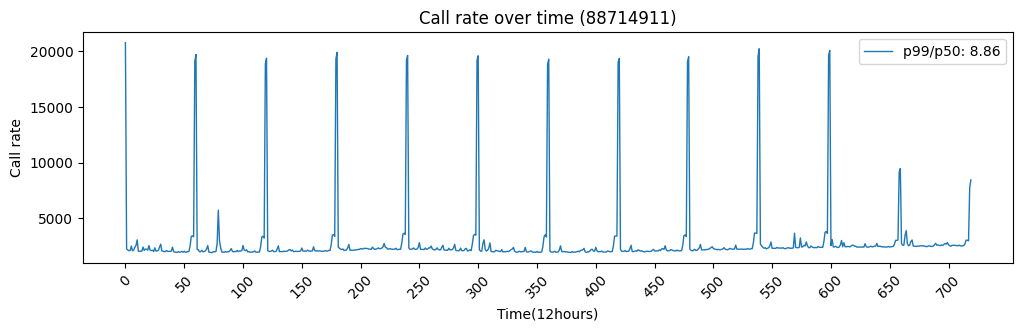

3


4


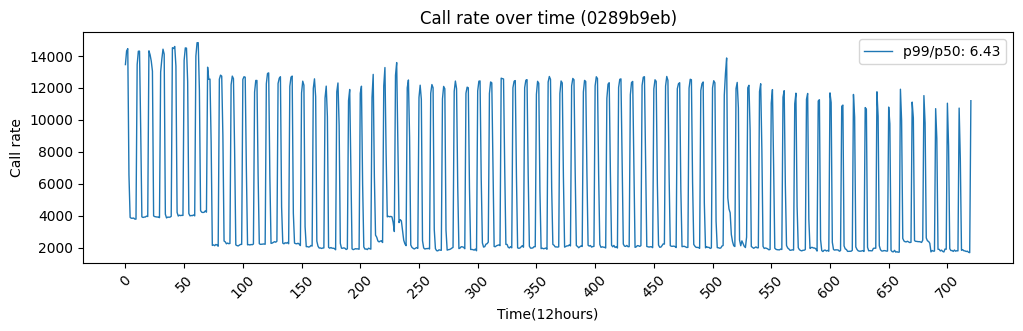

5


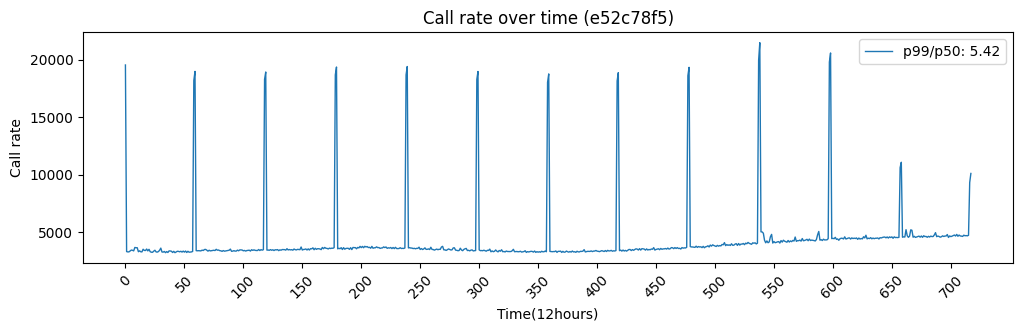

6


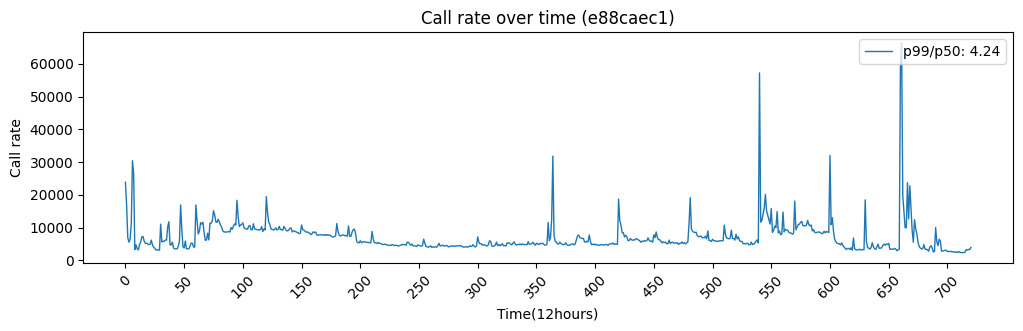

7


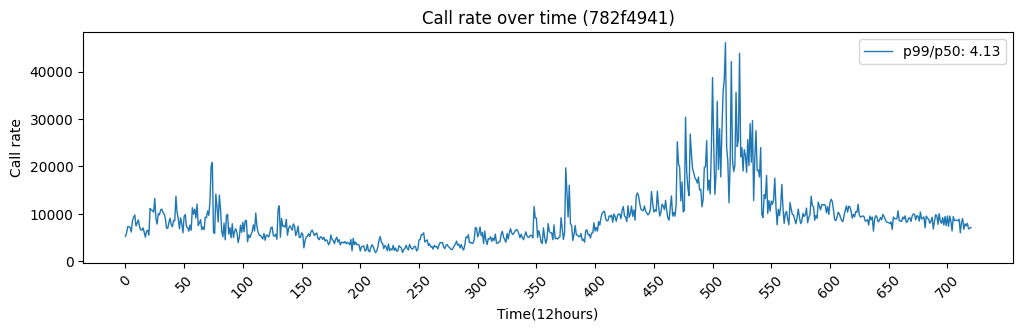

8


9


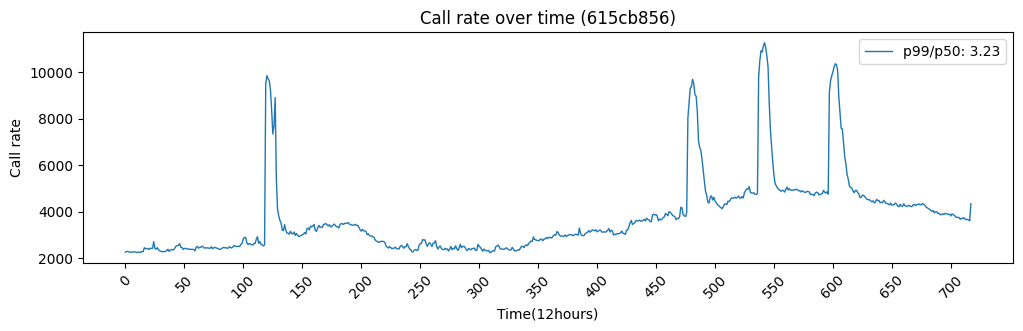

In [73]:
for i in range(10):
    print(i)
    wrapper_plot_entire_call_rate_trend(i)

In [75]:
def wrapper_plot_partial_call_rate_trend(ms_idx, start_idx, end_idx):
    temp_mcr_trend = target_df.loc[ms_idx, "li"][start_idx:end_idx]
    plot_partial_call_rate_trend(timestamps[start_idx:end_idx], temp_mcr_trend, "Call rate over time (" + target_df.loc[ms_idx, "msname"][:8] + ")", xl="Time(12hours)", yl="Call rate", label_ = target_df.loc[ms_idx, "p99/p50"])

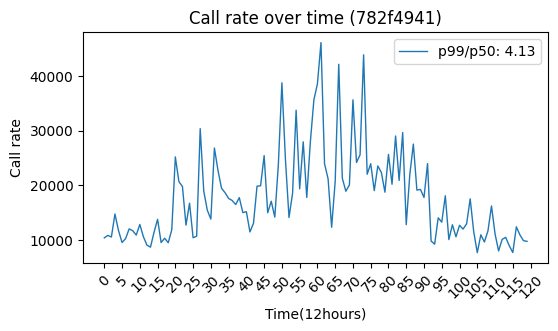

In [80]:
wrapper_plot_partial_call_rate_trend(7, 450, 570)

In [38]:
''' target_df = filtered_df '''
# start_idx = 120
# end_idx = 140
# temp_mcr_trend = target_df.loc[2, "li"][start_idx:end_idx]
# plot_partial_call_rate_trend(timestamps[start_idx:end_idx], temp_mcr_trend, "Call rate over time (" + target_df.loc[2, "msname"][:8] + ")", xl="Time(12hours)", yl="Call rate", label_ = str(target_df.loc[2, "p99/p50"]))

' target_df = filtered_df '

In [39]:
''' target_df = filtered_df '''
# ms_idx = 0
# start_idx = 55
# end_idx = 70
# temp_mcr_trend = target_df.loc[ms_idx, "li"][start_idx:end_idx]
# for i in range(start_idx, end_idx):
#     print(int(target_df.loc[ms_idx, "li"][i]), end=", ")
# plot_partial_call_rate_trend(timestamps[start_idx:end_idx], temp_mcr_trend, "Call rate over time (" + target_df.loc[ms_idx, "msname"][:8] + ")", xl="Time(12hours)", yl="Call rate", label_ = str(target_df.loc[2, "p99/p50"]))

' target_df = filtered_df '

In [40]:
''' target_df = filtered_df '''
# ms_idx = 2
# start_idx = 680
# end_idx = 700
# temp_mcr_trend = target_df.loc[ms_idx, "li"][start_idx:end_idx]
# for i in range(start_idx, end_idx):
#     print(int(target_df.loc[ms_idx, "li"][i]), end=", ")
# plot_partial_call_rate_trend(timestamps[start_idx:end_idx], temp_mcr_trend, "Call rate over time (" + target_df.loc[ms_idx, "msname"][:8] + ")", xl="Time(12hours)", yl="Call rate", label_ = str(target_df.loc[2, "p99/p50"]))

' target_df = filtered_df '